# dimensionality

Investigate how the average distance between a set of points changes as the dimensionality of the space increases.

## Packages for computation and data manipulation

In [1]:
import numpy as np # for number crunching
import pandas as pd # for data loading and manipulation
import time
import pickle
import re
import random
import itertools
from itertools import groupby
import collections
from collections import Counter
from collections import defaultdict
from datetime import datetime, timedelta
import string
import io

from scipy.spatial import distance
from scipy.spatial.distance import cdist
from scipy.spatial import Voronoi # for showing cluster boundaries

from sklearn.metrics import pairwise_distances

# Plotting
# Import the pyplot module from the matplotlib library
from matplotlib import pyplot as plt
import seaborn as sns

## Approach 1 - What happens to the Euclidean distances between points in a hypercube as the number of dimensions of that hypercube increases? 

 - Generate an array of vectors with array size m rows and n columns
 - These arrays can be of two kinds.
  - Case 1: The first kind of array is when each vector in the array is the same as every other vector in the array. This is the case in which we start out with n points in a one-dimensional space and ask how these same points are distributed as we increase the dimensions. Same points, 
  - Case 2: The second kind of array is when each vector in the array is different from every other vector in the array. This is the general case of having the same number of points but the points in each dimension are different from the points in the higher dimension. Intuitively, this is not the case that we want. 
 - Case 1
  - Generate an m x n array where the row vectors are exactly the same. Use the repeat_array function with repeat_array=1.
  - Find the average distance between the points on a single vector. 
  - Then take a 2, 3, 4, ... m vectors and transpose them. This will render them in the form that the same set of points are being put into higher dimensions. Find the average pairwise distance between these vectors. This measures the way in which dimensionality makes distances greater and washes out similarity because ultimately everything is sufficiently far from everthing.
 - Case 2
  - Generate an m x n array where the row vectors are different. Use repeat_array=0. The rest of the steps are the same as Case 1.
  - Since there can be different points in different dimensions, the results are less stable in terms of the conclusions we can draw about the rate of change of average distance, for example.
  
## Approach 2 - Density of points in an n-dimensional hypercube

Another way to think about this is as a measure of density where density is the number of points in the hypercube divided by the volume of the hypercube. The volume of an n-dimensional hypercube with edge length r is $r^n$. So we can ask: if we have N points in a single dimension of edge length L, how many points will we need in m dimensions if we want to preserve the same density of points? 

## Observation

The volume of a hypercube grows very fast but the actual distances between points in the hypercube grow at a _much slower_ and more manageable rate. The curse of dimesionality isn't as potent as you may think.

## Approach 1

In [4]:
def create_data_array_OLD(m_rows, n_cols, repeat_array=1):
    '''
    #### DEPRECATED ####
    create_data_array below is more flexible.
    #### ####
    
    Create an num_rows x num_cols array of random values in the interval (0, 1]. 
    num_rows is the dimensionality of the space and num_cols is the number of points 
    along any single dimension.
    
    When repeat_array = 0, the rows contain differnt vectors. E.g., [[0.1, 0.2], [0.5, 0.8], [0.2, 0.7]]
    When repeat_array = 1 (default), the rows all contain the same vector. E.g., [[0.1, 0.2], [0.1, 0.2], [0.1, 0.2]]
    
    REQUIRES numpy
    
    '''
    if repeat_array == 1:
        # Create the base vector
        vec = np.random.random_sample(size=(1, n_cols))
        # Create num_rows replicas of vec to form the array
        vec_array = np.repeat(vec, m_rows, axis=0)
    else:
        vec_array = np.random.random_sample(size=(m_rows, n_cols))
        
    return vec_array

In [128]:
def create_data_array(m_rows, n_cols, repeat_array=1, low=0.0, high=1.0, custom_vec=[]):
    '''
    Create an num_rows x num_cols array of random values in the interval (0, 1]. 
    num_rows is the dimensionality of the space and num_cols is the number of points 
    along any single dimension.
    
    When repeat_array = 0, the rows contain differnt vectors. E.g., [[0.1, 0.2], [0.5, 0.8], [0.2, 0.7]]
    When repeat_array = 1 (default), the rows all contain the same vector. E.g., [[0.1, 0.2], [0.1, 0.2], [0.1, 0.2]]
    low and high set the closed interval on which the random points are generated
    custom_vector allows for introducing a hand-made vector as the base vector. For example, [0.25, 0.5, 0.75, 1.0], 
    which gives the user full control over the range of points. NOTE: if a custom_vector is set, then repeat_array MUST BE
    set to 1; otherwise it would make no sense just to have control over the first vector in the array. 
    
    REQUIRES numpy
    
    '''
    #### Input Checks ####
    
    if (len(custom_vec) > 0) and (repeat_array == 0):
        return print("If you use a custom vector, please set repeat_array=1")
    
    if (len(custom_vec) > 0) and (n_cols != len(custom_vec)):
        return print("The value of n_cols must equal the length of the custom vector.")
    
    if (len(custom_vec) > 0) and (custom_vec[-1] > high):
        return print("The last element of the custom vector must be less than or equal to the high value.")
    
    #### END Input Checks ####
    
    if repeat_array == 1:
        # Create the base vector
        if len(custom_vec) == 0:
            vec = np.random.uniform(low=low, high=high, size=(1, n_cols))
        else:
            vec = [custom_vec]
        # Create num_rows replicas of vec to form the array
        vec_array = np.repeat(vec, m_rows, axis=0)
    else:
        vec_array = np.random.uniform(low=low, high=high, size=(m_rows, n_cols))
        
    return vec_array

In [38]:
np.random.uniform(low=0.0, high=1.0, size=(2,3))

array([[0.69745339, 0.59583616, 0.71671396],
       [0.19725734, 0.41702674, 0.74585486]])

In [42]:
create_data_array(m_rows=5, n_cols=4, repeat_array=1, low=0.0, high=3.0, custom_vec=[])

array([[0.13481396, 0.4811487 , 1.8708794 , 0.51678294],
       [0.13481396, 0.4811487 , 1.8708794 , 0.51678294],
       [0.13481396, 0.4811487 , 1.8708794 , 0.51678294],
       [0.13481396, 0.4811487 , 1.8708794 , 0.51678294],
       [0.13481396, 0.4811487 , 1.8708794 , 0.51678294]])

In [43]:
vec_array = create_data_array(m_rows=10, n_cols=3, repeat_array=0, low=1.0, high=2.0, custom_vec=[])
vec_array

array([[1.98554822, 1.86906402, 1.20178848],
       [1.76348933, 1.39200957, 1.8574237 ],
       [1.42974905, 1.49248374, 1.83860311],
       [1.35980768, 1.30971622, 1.54908216],
       [1.52464381, 1.21820006, 1.37906848],
       [1.12333142, 1.84866562, 1.46455156],
       [1.19978048, 1.77507764, 1.61076954],
       [1.44569393, 1.52422086, 1.87021148],
       [1.43584162, 1.78956053, 1.54234736],
       [1.88831739, 1.83766323, 1.11786919]])

In [44]:
def single_vector_distances(vector):
    '''
    Given a vector such as [0.2, 0.3, 0.76], find the pairwise distances between
    the elements. Calculate the descriptive stats for these pairwise distances -- max, min, mean, and std dev.
    
    REQUIRES numpy
    
    '''
    # Get the pairwise distances as a one-dimensional array
    pairwise_dists = np.reshape([np.abs(vector[i] - vector[j]) for i in range(len(vector)) for j in range(len(vector))], (1, -1))[0]
    
    # Remove the zeros from the pairwise_distances vector 
    ## This ensures that the mean is larger than it would otherwise be and accurately reflects how average distances
    ## between points grows as dimensionality increases.
    
    non_zero_distances = [x for x in pairwise_dists if x > 0]
    
    return [np.mean(non_zero_distances), np.std(non_zero_distances), np.max(non_zero_distances), np.min(non_zero_distances)]

In [45]:
single_vector_distances(vec_array[0])

[0.5225064887373422,
 0.2910128509957584,
 0.7837597331060133,
 0.11648419502356555]

In [46]:
vec_array_test = vec_array[0:6]
vec_array_test

array([[1.98554822, 1.86906402, 1.20178848],
       [1.76348933, 1.39200957, 1.8574237 ],
       [1.42974905, 1.49248374, 1.83860311],
       [1.35980768, 1.30971622, 1.54908216],
       [1.52464381, 1.21820006, 1.37906848],
       [1.12333142, 1.84866562, 1.46455156]])

In [47]:
def multiple_vector_distances(vector_array): 
    '''
    Given a vector_array such as such as [[0.2, 0.3, 0.76],[0.2, 0.3, 0.76],[0.2, 0.3, 0.76]] 
    (in this case each vector in the array is the same, but they don't have to be), find the 
    pairwise distances between each vector in the vector_array. 
    
    Calculate the descriptive statistics for the pairwise distances -- mean, std dev, max, and min.
    OBSERVATION: The length of the vector_array is a measure of the dimensionality of the space.
    
    REQUIRES numpy, from sklearn.metrics import pairwise_distances
    
    '''
    
    # First transpose the vector_array
    ## This ensures that when the vectors are the same the 
    ## same points that are on a single dimension are represented in multiple dimensiions. 
    ## When the vectors in the vector_array are different we don't have to transpose -- but it doesn't change
    ## anything and it keeps the code simpler to handle both types of vector_arrays with a single function.
    vec_array_transp = np.transpose(vector_array)
    
    # Find the pairwise distances between each vector in the array 
    ## and flatten the array into a one-row vector
    pairwise_dists = np.reshape(pairwise_distances(vec_array_transp), (1, -1))[0]
    
    # Drop the zeros
    non_zero_distances = [x for x in pairwise_dists if x > 0]
    
    # Return the descriptive stats
    return [np.max(non_zero_distances), np.mean(non_zero_distances), np.std(non_zero_distances), np.min(non_zero_distances)]

In [48]:
multiple_vector_distances(vec_array_test)

[1.0061728926687847,
 0.9566402082029076,
 0.05367580807084539,
 0.8820589742678864]

## How does the average distance between points vary as dimensionality increases? 

## How many points do we need to preserve the same density as the dimensions of the hypercube increases? 

In [270]:
def distance_per_dimension(num_points, num_dims, repeat_array=1, low=0.0, high=1.0, custom_vec=[]):
    '''
    Imagine you have num_points number of points on a line. These are randomly generated points in 
    the interval (0.0, 1.0]. What happens to the average distance between these points as they are placed
    in spaces with dimensions from 1 to num_dims?
    
    Specifying a custom vector helps us to use non-random points on any edge length we choose. 
    low and high set the values of the interval over which the points are generated.
    
    USES create_data_array, single_vector_distances, multiple_vector_distances
    
    REQUIRES seaborn, matplotlib, pandas
    
    '''
    #### Input Checks ####
    
    if num_points < 2:
        return print("Plese enter num_points of 2 or greater.")
    
    if num_dims < 3:
        return print("please enter num_dims of 3 or greater.")
    
    if (len(custom_vec) > 0) and (repeat_array == 0):
        return print("If you use a custom vector, please set repeat_array=1")
    
    if (len(custom_vec) > 0) and (num_points != len(custom_vec)):
        return print("The value of num_points must equal the length of the custom vector.")
    
    if (len(custom_vec) > 0) and (custom_vec[-1] > high):
        return print("The last element of the custom vector must be less than or equal to the high value.")
    
    #### END Input Checks ####
    
    t0 = time.time()
    
    # Create a vector array
    ## The value of m_rows is the number of dimensions and n_cols the number of points for which
    ## we calculate the results.
    vector_array = create_data_array(m_rows=num_dims, n_cols=num_points, repeat_array=repeat_array, low=low, high=high, custom_vec=custom_vec)

    # Starting with dimensionality = 1 and ending with dimensionality = m_rows, find the 
    ## pairwise distance descriptive stats for the vector arrays. 
    dimensions_list = list(range(1, num_dims+1))
    descriptive_stats = []
    for i in range(num_dims):
        if i == 0:
            # Calculate the stats for a single vector
            desc_stats = single_vector_distances(vector_array[i])
        else:
            # Calculate the stats for each dimension
            desc_stats = multiple_vector_distances(vector_array[0:i+1])
        
        # Add the dimension number to the descriptive stats
        desc_stats = [dimensions_list[i]] + desc_stats
        descriptive_stats.append(desc_stats)

    # descriptive stats now contains all the information we need

    # Create a dataframe to view the results easily
    df_desc_stats = pd.DataFrame(descriptive_stats, columns=['Number of Dimensions', 
                                                             'Max Distance Between Points', 
                                                             'Mean Distance Between Points', 
                                                             'Std Dev Distance Between Points', 
                                                             'Min Distance Between Points'])
    
    
    # Calculate the overall percentage growth of the distances
    max_distance_vals = df_desc_stats['Max Distance Between Points'].values
    max_distance_perc_change = round(((max_distance_vals[-1] - max_distance_vals[0])/max_distance_vals[0])*100)
    mean_distance_vals = df_desc_stats['Mean Distance Between Points'].values
    mean_distance_perc_change = round(((mean_distance_vals[-1] - mean_distance_vals[0])/mean_distance_vals[0])*100)
    std_distance_vals = df_desc_stats['Std Dev Distance Between Points'].values
    std_distance_perc_change = round(((std_distance_vals[-1] - std_distance_vals[0])/std_distance_vals[0])*100)
    min_distance_vals = df_desc_stats['Min Distance Between Points'].values
    min_distance_perc_change = round(((min_distance_vals[-1] - min_distance_vals[0])/min_distance_vals[0])*100)
    
    # Calculate the percentage change in distance values from one dimension to the next
    pct_changes = []
    pct_changes_max = df_desc_stats['Max Distance Between Points'].pct_change()[1:].values
    pct_changes.append(pct_changes_max)
    pct_changes_mean = df_desc_stats['Mean Distance Between Points'].pct_change()[1:].values
    pct_changes.append(pct_changes_mean)
    pct_changes_std = df_desc_stats['Std Dev Distance Between Points'].pct_change()[1:].values
    pct_changes.append(pct_changes_std)
    pct_changes_min = df_desc_stats['Min Distance Between Points'].pct_change()[1:].values
    pct_changes.append(pct_changes_min)
    
    # pct_changes now contains all the information about the percentage change of distances by dimension
    df_pct_changes = pd.DataFrame(np.transpose(pct_changes), columns=['% Change of Max Distance Between Points', 
                                                                      '% Change of Mean Distance Between Points', 
                                                                      '% Change of Std Dev Distance Between Points', 
                                                                      '% Change of Min Distance Between Points'])
    
    
    
    # Approach 2
    if len(custom_vec) > 0:
        hypercube_edge_length = custom_vec[-1] - 0.0
    else:
        hypercube_edge_length = high
        
    density = round(num_points/(hypercube_edge_length), 3)
    #print(density)
    num_equiv_points = [round(density*(hypercube_edge_length**i)) for i in range(1,num_dims+1)]
    #print(num_equiv_points)
    
    # Plot the results
    
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    plt.suptitle("Hypercube Edge Length = " + str(hypercube_edge_length), fontsize='16')
    
    # plot of distances
    df_plot = df_desc_stats.drop(['Number of Dimensions'], axis=1)
    sns.lineplot(data=df_plot, ax=ax1);
    ax1.set_title('Distance Between ' + str(num_points) + ' Points As Dimensionality Increases', fontsize='14')
    ax1.set_xlabel("Number of Dimensions", fontsize='14')
    ax1.set_ylabel("Distance", fontsize='14');
    ax1.grid(True)
    
    # plot of perc changes in distances
    #sns.lineplot(data=df_pct_changes, ax=ax2);
    #ax2.set_xlabel("Number of Dimensions", fontsize='14')
    #ax2.set_ylabel("% Change in Distance", fontsize='14');
    #ax2.grid(True)
    
    # plot the equivalent density 
    plt.plot(num_equiv_points);
    ax2.set_xlabel("Number of Dimensions", fontsize='14')
    ax2.set_ylabel("Number of Points to Preserve Density", fontsize='14');
    ax2.grid(True)
    
    #plt.tight_layout()
    
    t1 = time.time()
    print("Calculations completed in {} seconds.".format(round(t1-t0, 3)))
    print("The {} points on a single dimension are: {}".format(num_points, vector_array[0]))
    print("Max Distance Percentage Change = {}%".format(max_distance_perc_change))
    print("Mean Distance Percentage Change = {}%".format(mean_distance_perc_change))
    print("Std Dev Distance Percentage Change = {}%".format(std_distance_perc_change))
    print("Min Distance Percentage Change = {}%".format(min_distance_perc_change))
    
    return [df_desc_stats, df_pct_changes]

## Try It Out

[4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152]
Calculations completed in 0.128 seconds.
The 4 points on a single dimension are: [0.5 1.  1.5 2. ]
Max Distance Percentage Change = 705%
Mean Distance Percentage Change = 900%
Std Dev Distance Percentage Change = 11%
Min Distance Percentage Change = 347%


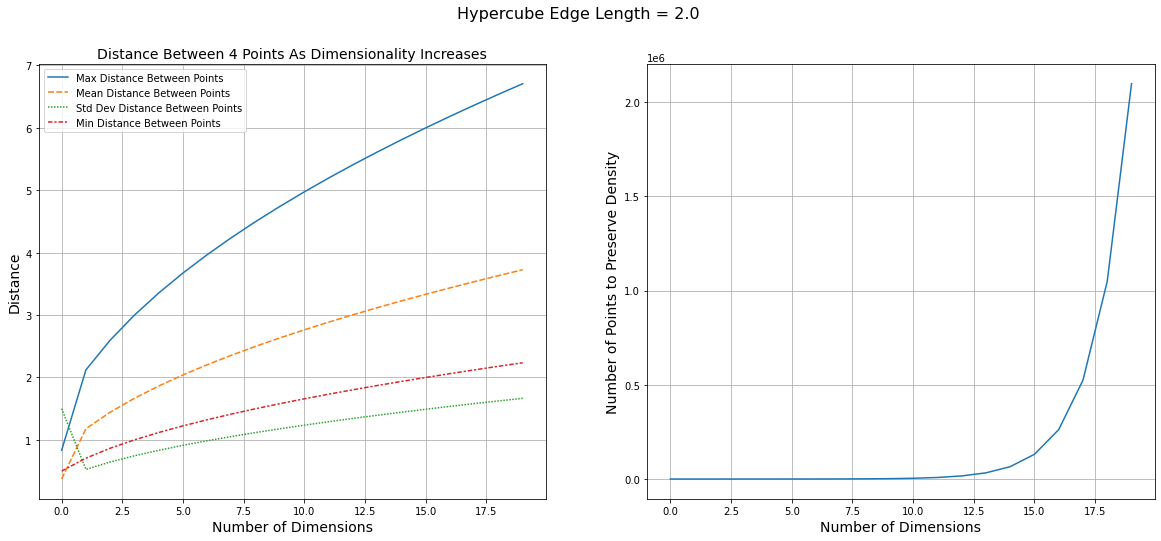

In [276]:
# Enter values for
## num_points - the number of points you want to place in a hypercube
## num_dims - the highest dimension hyercube you'd like to place the points in
## Best to leave the other input values alone to start; play around with them once you're comfortable with what's up

[df_desc_stats, df_pct_changes] = distance_per_dimension(num_points=4, num_dims=20, repeat_array=1, low=0.0, high=2.0, custom_vec=[0.5, 1.0, 1.5, 2.0])

In [228]:
df_desc_stats

,Number of Dimensions,Max Distance Between Points,Mean Distance Between Points,Std Dev Distance Between Points,Min Distance Between Points
0,1,0.916667,0.606676,1.750000,0.250000
1,2,2.474874,1.296362,0.857969,0.353553
2,3,3.031089,1.587713,1.050793,0.433013
3,4,3.500000,1.833333,1.213352,0.500000
4,5,3.913119,2.049729,1.356568,0.559017
...,...,...,...,...,...
995,996,55.229068,28.929512,19.146366,7.889867
996,997,55.256787,28.944031,19.155975,7.893827
997,998,55.284491,28.958543,19.165580,7.897784
998,999,55.312182,28.973048,19.175179,7.901740


In [229]:
df_pct_changes

,% Change of Max Distance Between Points,% Change of Mean Distance Between Points,% Change of Std Dev Distance Between Points,% Change of Min Distance Between Points
0,1.699862,1.136829,-0.509732,0.414214
1,0.224745,0.224745,0.224745,0.224745
2,0.154701,0.154701,0.154701,0.154701
3,0.118034,0.118034,0.118034,0.118034
4,0.095445,0.095445,0.095445,0.095445
...,...,...,...,...
994,0.000502,0.000502,0.000502,0.000502
995,0.000502,0.000502,0.000502,0.000502
996,0.000501,0.000501,0.000501,0.000501
997,0.000501,0.000501,0.000501,0.000501
